In [ ]:
!nvidia-smi

Wed Oct 23 18:01:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
import numpy as np
import time

def cpu_vector_addition(a, b):
    return a + b

def measure_cpu_time(size):
    a = np.random.rand(size)
    b = np.random.rand(size)

    start_time = time.time()
    result = cpu_vector_addition(a, b)
    end_time = time.time()

    return end_time - start_time

In [ ]:
pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660545 sha256=61f234ebfc06df6ea6c9a9419f153bfc10aa50bc5f894ed0a773604740e94844
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


Vector Length | CPU Time (s) | GPU Time (s) | Speedup
-----------------------------------------------------------------
1000          | 0.002082 | 0.000949 | 2.19x
10000         | 0.006264 | 0.000635 | 9.86x
50000         | 0.036327 | 0.000813 | 44.66x
100000        | 0.060369 | 0.001458 | 41.40x


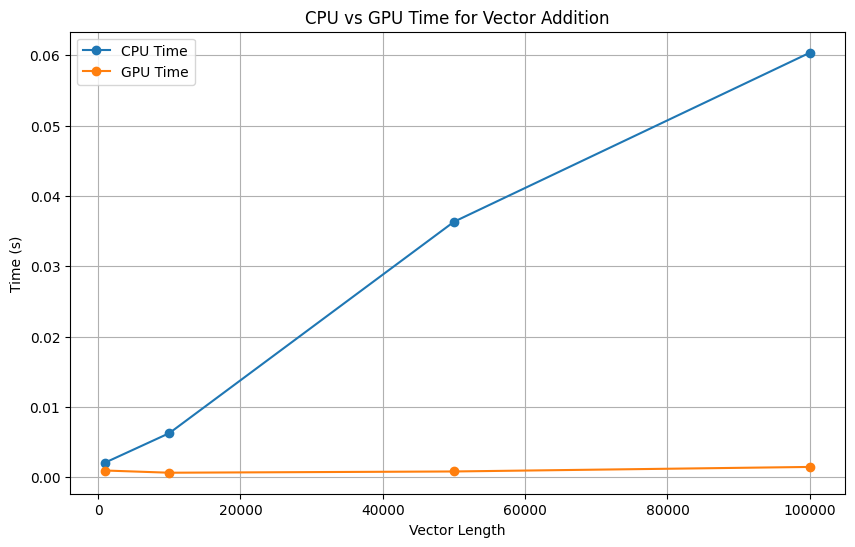

In [48]:
import pycuda.driver as cuda
import pycuda.autoinit
from matplotlib import pyplot as plt
from pycuda.compiler import SourceModule
import numpy as np
import cupy as cp
import time


def vector_addition_cpu(vector1, vector2):
    if len(vector1) != len(vector2):
        raise ValueError("Vectors must be of the same length")

    result = np.zeros_like(vector1)
    start = time.time()
    for i in range(len(vector1)):
        result[i] = vector1[i] + vector2[i]
    end = time.time()
    return result, end - start


vector_sum_kernel = ("""
__global__ void vectorAdditionKernel(float* res, float* a, float* b, unsigned int size) {
    for (int i = blockIdx.x * blockDim.x + threadIdx.x; i < size; i += blockDim.x * gridDim.x)
        res[i] = a[i] + b[i];
}
""")


def vector_addition_gpu(vector1, vector2):
    if len(vector1) != len(vector2):
        raise ValueError("Vectors must be of the same length")

    start_time = time.time()

    block_size = 256
    grid_size = (len(vector1) + block_size - 1) // block_size

    res = np.zeros_like(vector1, dtype=np.float32)
    vec1_gpu = cuda.mem_alloc(vector1.nbytes)
    vec2_gpu = cuda.mem_alloc(vector2.nbytes)
    result_gpu = cuda.mem_alloc(res.nbytes)

    cuda.memcpy_htod(vec1_gpu, vector1)
    cuda.memcpy_htod(vec2_gpu, vector2)
    cuda.memcpy_htod(result_gpu, res)

    mod = SourceModule(vector_sum_kernel)
    vector_addition = mod.get_function("vectorAdditionKernel")
    vector_addition(result_gpu, vec1_gpu, vec2_gpu, np.uint32(len(vector1)), block=(block_size, 1, 1), grid=(grid_size, 1))
    cuda.Context.get_current().synchronize()

    cuda.memcpy_dtoh(res, result_gpu)
    end_time = time.time()

    return res, end_time - start_time


def compare_vector_addition_times(vector_lengths):
    results = []
    for length in vector_lengths:
        vector1 = np.random.rand(length).astype(np.float32)
        vector2 = np.random.rand(length).astype(np.float32)

        cpu_result, cpu_time = vector_addition_cpu(vector1, vector2)
        gpu_result, gpu_time = vector_addition_gpu(vector1, vector2)

        # Проверка результатов
        if not np.allclose(cpu_result, gpu_result):
            raise ValueError("Results do not match!")

        speedup = cpu_time / gpu_time
        results.append((length, cpu_time, gpu_time, speedup))

    return results


def print_results_table(results):
    print("Vector Length | CPU Time (s) | GPU Time (s) | Speedup")
    print("-" * 65)
    for length, cpu_time, gpu_time, speedup in results:
        print(f"{length:<13} | {cpu_time:.6f} | {gpu_time:.6f} | {speedup:.2f}x")


def plot_results(results):
    lengths = [result[0] for result in results]
    cpu_times = [result[1] for result in results]
    gpu_times = [result[2] for result in results]

    plt.figure(figsize=(10, 6))
    plt.plot(lengths, cpu_times, label='CPU Time', marker='o')
    plt.plot(lengths, gpu_times, label='GPU Time', marker='o')
    plt.xlabel('Vector Length')
    plt.ylabel('Time (s)')
    plt.title('CPU vs GPU Time for Vector Addition')
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    vector_lengths = [1000, 10000, 50000, 100000]
    results = compare_vector_addition_times(vector_lengths)
    print_results_table(results)
    plot_results(results)